In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as vdatasets
import torchvision.utils as vutils
import random
from tensorboardX import SummaryWriter
import os
torch.manual_seed(1)

DATA_PATH = os.environ['DATA_PATH']
USE_CUDA = torch.cuda.is_available()

import matplotlib.pyplot as plt
%matplotlib inline

### FashionMNIST 

In [3]:
train_dataset = vdatasets.FashionMNIST(root=DATA_PATH+'FM/',
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                           num_workers=2)

test_dataset = vdatasets.FashionMNIST(root=DATA_PATH+'FM/',
                               train=False, 
                               transform=transforms.ToTensor(),
                               download=True)


test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                           num_workers=2)

In [7]:
train_dataset[0][0].size()

torch.Size([1, 28, 28])

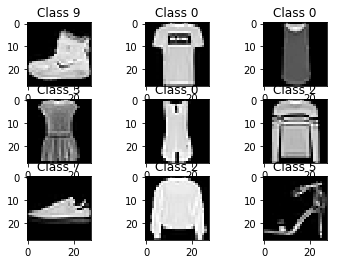

In [8]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_dataset[i][0].squeeze(0).numpy(), cmap='gray', interpolation='none')
    plt.title("Class {}".format(train_dataset[i][1]))

## Convolution layer 

In [9]:
sample_image = torch.randn(10,3,28,28) # 배치사이즈 B, 채널(RGB) C, 높이 H, 너비 W

In [10]:
convolution = nn.Conv2d(3,32,5) # in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1

In [11]:
convolutioned = convolution(Variable(sample_image))
convolutioned.size()

torch.Size([10, 32, 24, 24])

### TODO

Fashion MNIST 데이터셋 중 하나를 골라 convolution 결과 텐서의 사이즈가 (1,16,28,28)가 되도록 하시오 (커널 사이즈는 5x5)

In [12]:
sample_fmnist = random.choice(train_dataset)[0]
sample_fmnist.size()

torch.Size([1, 28, 28])

In [13]:
convolution = nn.Conv2d(1,16,5,padding=2) # (5-1)/2 = 2 paddings

In [15]:
sample_fmnist.unsqueeze(0).size()

torch.Size([1, 1, 28, 28])

In [16]:
convolutioned = convolution(Variable(sample_fmnist.unsqueeze(0)))

In [17]:
convolutioned.size()

torch.Size([1, 16, 28, 28])

## Pooling layer 

In [2]:
sample_image = torch.randn(1,1,4,4)

In [41]:
sample_image


(0 ,0 ,.,.) = 
  1.4299  0.6030  0.2310 -0.8852
 -1.0935  0.5040  1.2745  1.5891
  1.0622  0.4991 -0.8974  0.0695
  1.4051  0.3397 -0.7530  0.9124
[torch.FloatTensor of size 1x1x4x4]

In [3]:
maxpooling = nn.MaxPool2d(2) # kernel_size, stride=kernel_size,padding=0, dilation=1
avgpooling = nn.AvgPool2d(2) # kernel_size, stride=kernel_size,padding=0, dilation=1

maxpooled = maxpooling(Variable(sample_image))
avgpooled = avgpooling(Variable(sample_image))

In [49]:
maxpooled

Variable containing:
(0 ,0 ,.,.) = 
  1.4299  1.5891
  1.4051  0.9124
[torch.FloatTensor of size 1x1x2x2]

In [50]:
avgpooled

Variable containing:
(0 ,0 ,.,.) = 
  0.3608  0.5524
  0.8265 -0.1671
[torch.FloatTensor of size 1x1x2x2]

### TODO 

fully connected layer(self.fc)를 직접 작성하시오. 히든 레이어는 하나, 히든 노드수는 128로 지정하시오

In [18]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        # B,1,28,28
        
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(1,16,5,padding=2), # B,16,28,28
            nn.ReLU(),
            nn.MaxPool2d(2) # B,16,14,14
            )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(16,32,5,padding=2), # B,32,14,14
            nn.ReLU(),
            nn.MaxPool2d(2) # B,32,7,7
        )
        
        # reshape(view) : B,32*7*7
        
        self.fc = nn.Sequential(nn.Linear(32*7*7,128),
                                          nn.ReLU(),
                                          nn.Linear(128,10))
        
    def forward(self,inputs):
        inputs = self.conv_layer1(inputs)
        inputs = self.conv_layer2(inputs)
        return self.fc(inputs.view(inputs.size(0),-1))        

In [84]:
EPOCH=3
LR=0.01
BATCH_SIZE=64

model = CNN()
if USE_CUDA:
    model = model.cuda()
loss_function = nn.CrossEntropyLoss() # 소프트맥스 함수 포함하고 있음
optimizer = optim.Adam(model.parameters(), lr=LR)

In [85]:
for epoch in range(EPOCH):
    losses=[]
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = Variable(inputs), Variable(targets)
        if USE_CUDA:
            inputs,targets = inputs.cuda(),targets.cuda()
        model.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        losses.append(loss.data[0])
        if i % 100 == 0:
            print("[%d/%d] [%03d/%d] mean_loss : %.3f" % (epoch,EPOCH,i,len(train_loader),np.mean(losses)))
            losses=[]

[0/3] [000/938] mean_loss : 2.300
[0/3] [100/938] mean_loss : 0.826
[0/3] [200/938] mean_loss : 0.470
[0/3] [300/938] mean_loss : 0.467
[0/3] [400/938] mean_loss : 0.424
[0/3] [500/938] mean_loss : 0.388
[0/3] [600/938] mean_loss : 0.392
[0/3] [700/938] mean_loss : 0.356
[0/3] [800/938] mean_loss : 0.338
[0/3] [900/938] mean_loss : 0.352
[1/3] [000/938] mean_loss : 0.363
[1/3] [100/938] mean_loss : 0.341
[1/3] [200/938] mean_loss : 0.329
[1/3] [300/938] mean_loss : 0.306
[1/3] [400/938] mean_loss : 0.303
[1/3] [500/938] mean_loss : 0.312
[1/3] [600/938] mean_loss : 0.300
[1/3] [700/938] mean_loss : 0.308
[1/3] [800/938] mean_loss : 0.312
[1/3] [900/938] mean_loss : 0.326
[2/3] [000/938] mean_loss : 0.236
[2/3] [100/938] mean_loss : 0.286
[2/3] [200/938] mean_loss : 0.303
[2/3] [300/938] mean_loss : 0.281
[2/3] [400/938] mean_loss : 0.323
[2/3] [500/938] mean_loss : 0.296
[2/3] [600/938] mean_loss : 0.297
[2/3] [700/938] mean_loss : 0.296
[2/3] [800/938] mean_loss : 0.304
[2/3] [900/938

In [86]:
num_equal=0
for i, (inputs, targets) in enumerate(test_loader):
    inputs, targets = Variable(inputs), Variable(targets)
    outputs = model(inputs)
    
    outputs = outputs.max(1)[1] # argmax
    num_equal += torch.eq(outputs,targets).sum().data[0]
    
    
print("Accuracy : " ,num_equal/len(test_dataset))

Accuracy :  0.8817
